# Red Neuronal Perceptrón Multicapa (MLP)para Clasificación de Iris Setosa

Vamos a crear una red neuronal MLP pequeña para clasificar la flor Iris Setosa usando sólo NumPy. Implementaremos todo desde cero, incluyendo:

* Pasada hacia adelante
* Función de pérdida (entropía cruzada)
* Retropropagación del error
* Actualización de parámetros

Ejecute las celdas, pero estudie el código y el texto para comprender el funcionamiento.

## Importación de bibliotecas

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

## Clase MLP

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class MLP:
    """
    Una red neuronal perceptrón multicapa (MLP) para clasificación multiclase.
    
    Arquitectura:
    - Capa de entrada: 4 neuronas (características de las flores)
    - Capa oculta: 5 neuronas con activación ReLU
    - Capa de salida: 3 neuronas con activación softmax (para clasificación de 3 clases)
    
    Usamos entropía cruzada categórica como función de pérdida.
    """
    
    def __init__(self, input_size=4, hidden_size=5, output_size=3):
        """
        Inicializa los parámetros de la red.
        
        Args:
            input_size (int): Número de características de entrada
            hidden_size (int): Número de neuronas en la capa oculta
            output_size (int): Número de neuronas en la capa de salida (clases)
        """
        # Inicialización de pesos con Xavier/Glorot initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def forward(self, X):
        """
        Propagación hacia adelante (forward pass).
        
        Args:
            X (np.array): Datos de entrada (shape: n_muestras x n_características)
            
        Returns:
            tuple: (salida_capa_oculta, salida_red)
        """
        # Capa oculta
        self.z1 = np.dot(X, self.W1) + self.b1  # Combinación lineal
        self.a1 = self.relu(self.z1)             # Activación ReLU
        
        # Capa de salida
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Combinación lineal
        self.a2 = self.softmax(self.z2)               # Activación softmax
        
        return self.a1, self.a2
    
    def backward(self, X, y, a1, a2, learning_rate):
        """
        Propagación hacia atrás (backward pass) y actualización de pesos.
        
        Args:
            X (np.array): Datos de entrada
            y (np.array): Etiquetas verdaderas (one-hot encoded)
            a1 (np.array): Salida de la capa oculta
            a2 (np.array): Salida de la red (predicciones)
            learning_rate (float): Tasa de aprendizaje
        """
        m = X.shape[0]  # Número de muestras
        
        # Cálculo de gradientes
        # Error en la capa de salida (derivada de la entropía cruzada + softmax)
        dz2 = a2 - y
        
        # Gradientes para los parámetros de la capa de salida
        dW2 = (1/m) * np.dot(a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        # Error en la capa oculta (propagación hacia atrás a través de ReLU)
        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(a1)
        
        # Gradientes para los parámetros de la capa oculta
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        # Actualización de parámetros (descenso de gradiente)
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def compute_loss(self, y_true, y_pred):
        """
        Calcula la pérdida de entropía cruzada categórica.
        
        Args:
            y_true (np.array): Etiquetas verdaderas (one-hot encoded)
            y_pred (np.array): Predicciones de la red
            
        Returns:
            float: Valor de la pérdida
        """
        # Evitar log(0) agregando un pequeño valor
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss
    
    def softmax(self, z):
        """Función de activación softmax."""
        # Estabilidad numérica: restar el máximo
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def relu(self, z):
        """Función de activación ReLU."""
        return np.maximum(0, z)
    
    def relu_derivative(self, a):
        """Derivada de la función ReLU."""
        return (a > 0).astype(float)
    
    def train(self, X, y, epochs=1000, learning_rate=0.01, verbose=100):
        """
        Entrena la red neuronal.
        
        Args:
            X (np.array): Datos de entrenamiento
            y (np.array): Etiquetas (one-hot encoded)
            epochs (int): Número de épocas de entrenamiento
            learning_rate (float): Tasa de aprendizaje
            verbose (int): Frecuencia de impresión de información
        """
        losses = []
        for epoch in range(1, epochs+1):
            # Forward pass
            a1, a2 = self.forward(X)
            
            # Cálculo de pérdida
            loss = self.compute_loss(y, a2)
            losses.append(loss)
            
            # Backward pass y actualización de pesos
            self.backward(X, y, a1, a2, learning_rate)
            
            if verbose and epoch % verbose == 0:
                print(f"Época {epoch}, Pérdida: {loss:.4f}")
        
        return losses
    
    def predict(self, X):
        """
        Realiza predicciones.
        
        Args:
            X (np.array): Datos de entrada
            
        Returns:
            np.array: Clases predichas (0, 1 o 2)
        """
        _, a2 = self.forward(X)
        return np.argmax(a2, axis=1)

## Carga de datos

In [3]:
# Cargar y preparar datos de Iris para clasificación multiclase
def load_iris_data_multiclass():
    iris = load_iris()
    X = iris.data
    y = iris.target.reshape(-1, 1)  # Convertir a 2D para OneHotEncoder
    
    # Convertir etiquetas a one-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y)
    
    # Dividir en conjuntos de entrenamiento y prueba CON STRATIFY
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42, stratify=y
    )
    
    # Normalizar características
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    return X_train, X_test, y_train, y_test, encoder

## Entrenamiento y prueba

In [4]:
%%timeit -n 1 -r 1

''' Entrenar y evaluar el modelo multiclase '''

# Cargar datos
X_train, X_test, y_train, y_test, encoder = load_iris_data_multiclass()

# Crear y entrenar modelo
model = MLP(input_size=4, hidden_size=5, output_size=3)
losses = model.train(X_train, y_train, epochs=5000, learning_rate=0.01, verbose=250)

# Evaluar
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Convertir one-hot encoding de vuelta a labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calcular exactitud usando sklearn.metrics.accuracy_score
train_acc = accuracy_score(y_train_labels, train_preds)
test_acc = accuracy_score(y_test_labels, test_preds)

print(f"\nExactitud en entrenamiento: {train_acc:.2%}")
print(f"Exactitud en prueba: {test_acc:.2%}")

Época 250, Pérdida: 0.6977
Época 500, Pérdida: 0.5539
Época 750, Pérdida: 0.4959
Época 1000, Pérdida: 0.4587
Época 1250, Pérdida: 0.4265
Época 1500, Pérdida: 0.3946
Época 1750, Pérdida: 0.3613
Época 2000, Pérdida: 0.3182
Época 2250, Pérdida: 0.2621
Época 2500, Pérdida: 0.2159
Época 2750, Pérdida: 0.1771
Época 3000, Pérdida: 0.1488
Época 3250, Pérdida: 0.1285
Época 3500, Pérdida: 0.1136
Época 3750, Pérdida: 0.1024
Época 4000, Pérdida: 0.0939
Época 4250, Pérdida: 0.0873
Época 4500, Pérdida: 0.0820
Época 4750, Pérdida: 0.0777
Época 5000, Pérdida: 0.0742

Exactitud en entrenamiento: 97.50%
Exactitud en prueba: 93.33%
571 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Explicación Detallada

### 1. Inicialización

Los pesos se inicializan usando la inicialización Xavier/Glorot, que ayuda a que los gradientes fluyan mejor al inicio.

`W1` y `b1` son los pesos y sesgos de la capa oculta.

`W2` y `b2` son los pesos y sesgos de la capa de salida.

### 2. Pasada hacia adelante

#### Capa oculta:

`z1 = X·W1 + b1`: Combinación lineal de entradas y pesos

`a1 = ReLU(z1)`: Aplicación de función de activación ReLU

### Capa de salida:

`z2 = a1·W2 + b2`: Combinación lineal

`a2 = softmax(z2)`: Función Softmax para obtener probabilidades entre 0 y 1

```python
def softmax(self, z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Para estabilidad numérica
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)
```

Softmax garantiza que las salidas sumen 1 (como probabilidades)

### 3. Cálculo de Pérdida

Usamos entropía cruzada binaria categórica:

```python
loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
```

Donde:

`y_true` es _one-hot encoded_ (ej. [1, 0, 0] para clase 0)

`y_pred` son las probabilidades de softmax

### 4. Retropropagación del error

#### Capa de salida:

El gradiente para softmax + entropía cruzada es sorprendentemente simple:

Error:
```python
dz2 = a2 - y  # derivada de la pérdida respecto a z2, igual que en el caso binario
```

#### Gradientes:

`dW2 = (1/m) * a1.T · dz2`

`db2 = (1/m) * sum(dz2)`

#### Capa oculta:

Error: `dz1 = (dz2 · W2.T) * ReLU'(a1)` (regla de la cadena)

#### Gradientes:

`dW1 = (1/m) * X.T · dz1`

`db1 = (1/m) * sum(dz1)`

### 5. Funciones de Activación

**ReLU**: `max(0, x)` - Simple y evita el problema de gradientes vanishing

**Sigmoid**: `1/(1 + e^-x)` - Para obtener probabilidades en la salida

### 6. Preparación de Datos

_One-hot encoding_ de las etiquetas:

```python
# Antes: [0, 1, 2]
# Después: [[1,0,0], [0,1,0], [0,0,1]]
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
```

### 7. Predicción

Para obtener la clase predicha:

```python
np.argmax(a2, axis=1)  # Devuelve el índice de la neurona con mayor probabilidad
```

### 8. Entrenamiento

El bucle de entrenamiento:

1. Calcula la pasada hacia adelante
2. Calcula la pérdida
3. Realiza la pasada hacia atrás
4. Actualiza pesos con descenso de gradiente

### 9. Explicación Matemática Detallada

#### Softmax

Para un vector de logits z = [z₁, z₂, z₃]:

$p_i = e^{z_i} / (∑_{j=1}^3 e^{z_j})$

#### Entropía Cruzada Categórica

Para una muestra con etiqueta verdadera y (one-hot) y predicción ŷ:

$L = -∑_{i=1}^3 y_i log(ŷ_i)$

#### Gradientes

La derivada de la pérdida respecto a los logits de salida (z₂) es:

$∂L/∂z₂ = ŷ - y$

Este gradiente es idéntico al caso binario, pero opera sobre vectores en lugar de escalares.

### 10. Resultados Esperados

Con este modelo se debería obtener:

* Precisión en entrenamiento > 95%
* Precisión en prueba > 90%

La red aprenderá a distinguir las 3 clases de flores Iris.

Este código implementa todos los componentes fundamentales de una red neuronal desde cero, usando solo operaciones matriciales de NumPy.

# Red Neuronal MLP para Iris con PyTorch

Esta es una implementación completa en PyTorch para clasificar las flores Iris (3 clases), con:

* 5000 épocas de entrenamiento
* Matriz de confusión
* Reporte de métricas (precision, recall, f1-score)
* Uso de funciones de accuracy de PyTorch/scikit-learn
* Código bien comentado comparando con la versión manual anterior

Al igual que con la implementación anterior corra la celda pero estudie el código con sus comentarios para comprender el funcionamiento y aprender a utilizar Pytorch.

Nota: Si desean utilizar GPU en lugar de CPU deben hacer una ligera modificación al código, aprenda como hacerlo investigando al respecto.

## Importación de bibliotecas

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

## Carga de datos

In [6]:
# 1. Cargar y preparar datos (similar a load_iris_data anterior)
def load_iris_data():
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    # Dividir en train/test (80/20) estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Normalizar (como en la versión manual)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Convertir a tensores PyTorch
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)  # Para CrossEntropyLoss
    X_test = torch.FloatTensor(X_test)
    y_test = torch.LongTensor(y_test)
    
    return X_train, X_test, y_train, y_test, iris.target_names

## Clase MLP

In [7]:
# 2. Definir la red neuronal (análogo a MLP anterior)
class MLP(nn.Module):
    def __init__(self, input_size=4, hidden_size=5, output_size=3):
        super().__init__()
        # Capa oculta (como W1 y b1 en la versión manual)
        self.hidden = nn.Linear(input_size, hidden_size)
        # Capa de salida (como W2 y b2)
        self.output = nn.Linear(hidden_size, output_size)
        # Función de activación ReLU
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Forward pass (igual que en la versión manual)
        x = self.hidden(x)      # z1 = X·W1 + b1
        x = self.relu(x)        # a1 = ReLU(z1)
        x = self.output(x)      # z2 = a1·W2 + b2
        # No aplicamos softmax aquí, CrossEntropyLoss lo incluye
        return x

## Entrenamiento y prueba

Entrenando modelo...
Época 500, Pérdida: 0.0414
Época 1000, Pérdida: 0.0370
Época 1500, Pérdida: 0.0360
Época 2000, Pérdida: 0.0354
Época 2500, Pérdida: 0.0350
Época 3000, Pérdida: 0.0347
Época 3500, Pérdida: 0.0345
Época 4000, Pérdida: 0.0344
Época 4500, Pérdida: 0.0342
Época 5000, Pérdida: 0.0341

Evaluación del modelo:

Exactitud: 96.67%

Matriz de Confusión:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



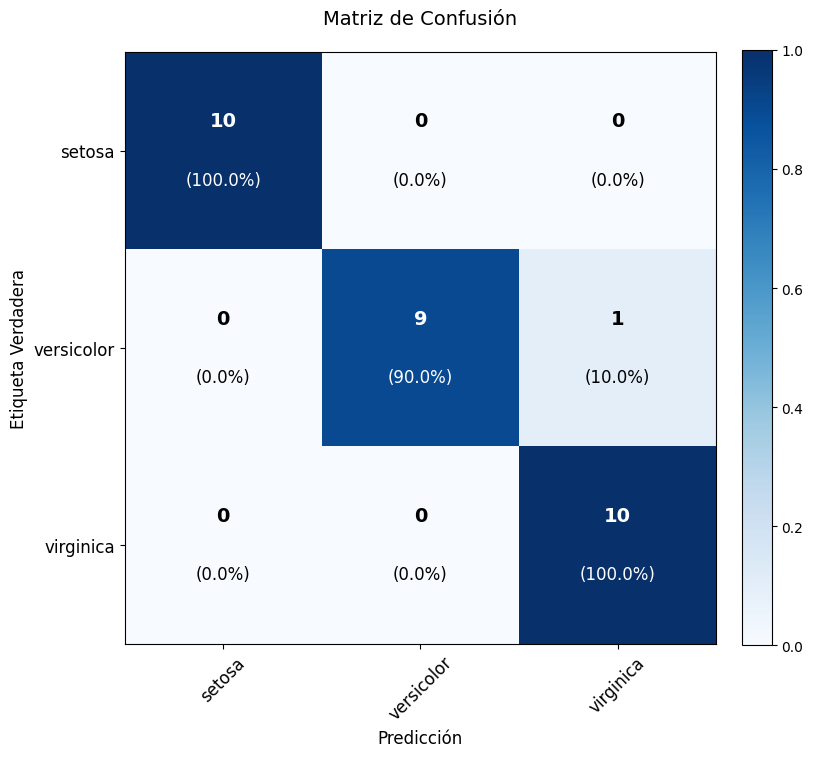

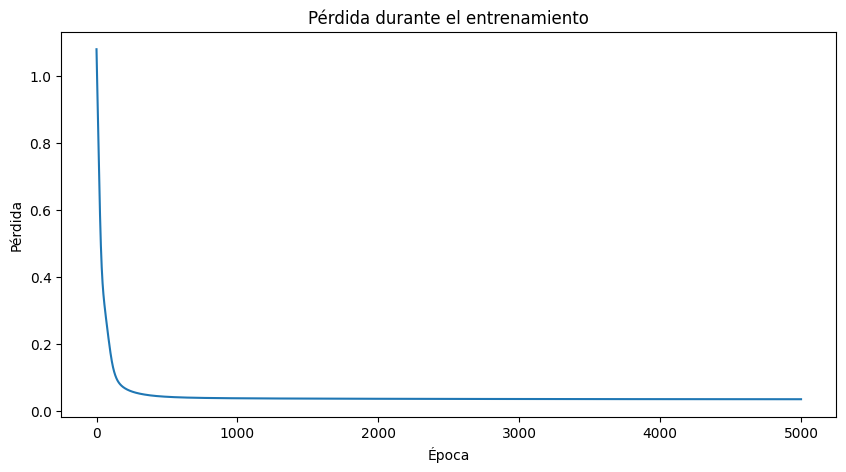

9.66 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
%%timeit -n 1 -r 1

# 3. Entrenamiento (análogo al train anterior pero con PyTorch)
def train_model(model, X_train, y_train, epochs=5000, lr=0.01):
    criterion = nn.CrossEntropyLoss()  # Incluye softmax + entropía cruzada
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Optimizador más avanzado
    
    losses = []
    for epoch in range(1, epochs+1):
        # PPasada hacia adelante
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Pasada hacia atrás y optimización (retropropagación automática)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f'Época {epoch}, Pérdida: {loss.item():.4f}')
    
    return losses

# 4. Evaluación y métricas
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    """Matriz combinada con valores absolutos y relativos"""
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    plt.title(title, pad=20, fontsize=14)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    # Umbral para color del texto
    thresh = 0.5
    
    # Añadir valores absolutos y porcentajes
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i-0.15, f"{cm[i, j]}",  # Valor absoluto arriba
                 ha='center', va='center',
                 color='white' if cm_norm[i, j] > thresh else 'black',
                 fontsize=14, fontweight='bold')
        
        plt.text(j, i+0.15, f"({cm_norm[i, j]:.1%})",  # Porcentaje abajo
                 ha='center', va='center',
                 color='white' if cm_norm[i, j] > thresh else 'black',
                 fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('Etiqueta Verdadera', fontsize=12)
    plt.xlabel('Predicción', fontsize=12)
    plt.show()

def evaluate_model(model, X_test, y_test, target_names):
    with torch.no_grad():
        outputs = model(X_test)
        _, preds = torch.max(outputs, 1)
        
        acc = accuracy_score(y_test, preds)
        print(f'\nExactitud: {acc:.2%}')
        
        cm = confusion_matrix(y_test, preds)
        print('\nMatriz de Confusión:')
        print(cm)
        
        print('\nReporte de Clasificación:')
        print(classification_report(y_test, preds, target_names=target_names))
        
        plot_confusion_matrix(cm, target_names)

# 5. Ejecución principal
# Cargar datos
X_train, X_test, y_train, y_test, target_names = load_iris_data()

# Crear modelo
model = MLP(input_size=4, hidden_size=5, output_size=3)

# Entrenar
print("Entrenando modelo...")
losses = train_model(model, X_train, y_train, epochs=5000)

# Evaluar
print("\nEvaluación del modelo:")
evaluate_model(model, X_test, y_test, target_names)

# Gráfico de pérdida
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Ejercicio: Implemente un MLP para los datos de diabetes manualmente

Implemente un MLP para los datos de indios de diabetes usando el método manual Numpy.  La implementación debe ser manual, igual al primer ejemplo de Iris Setosa.

Tenga en cuenta que como es un problema binario, no multiclase debe utilizar como función de activación final la sigmoide, no la softmax.

Además, la pérdida debe ser con entropía cruzada binaria. Esta función se define así:

$L = -[y·log(ŷ) + (1-y)·log(1-ŷ)]$

Donde:

`y` es la etiqueta verdadera (0 o 1)

`ŷ` es la predicción de la red (probabilidad entre 0 y 1)


In [11]:
import pandas as pd

class MLPBinary:
    """
    Red neuronal perceptrón multicapa para clasificación binaria.
    
    Arquitectura:
    - Capa de entrada: 8 neuronas (características de diabetes)
    - Capa oculta: 10 neuronas con activación ReLU
    - Capa de salida: 1 neurona con activación sigmoid (para clasificación binaria)
    
    Usamos entropía cruzada binaria como función de pérdida.
    """
    
    def __init__(self, input_size=8, hidden_size=10, output_size=1):
        """
        Inicializa los parámetros de la red.
        """
        # Inicialización de pesos con Xavier/Glorot initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def forward(self, X):
        """Propagación hacia adelante."""
        # Capa oculta
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Capa de salida (binaria con sigmoid)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        
        return self.a1, self.a2
    
    def backward(self, X, y, a1, a2, learning_rate):
        """Propagación hacia atrás y actualización de pesos."""
        m = X.shape[0]
        
        # Error en la capa de salida (derivada de entropía cruzada binaria + sigmoid)
        dz2 = a2 - y.reshape(-1, 1)
        
        # Gradientes para la capa de salida
        dW2 = (1/m) * np.dot(a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        # Error en la capa oculta
        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(a1)
        
        # Gradientes para la capa oculta
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        # Actualización de parámetros
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def compute_loss(self, y_true, y_pred):
        """
        Calcula la pérdida de entropía cruzada binaria.
        L = -[y·log(ŷ) + (1-y)·log(1-ŷ)]
        """
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        y_true = y_true.reshape(-1, 1)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def sigmoid(self, z):
        """Función de activación sigmoid."""
        # Evitar overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def relu(self, z):
        """Función de activación ReLU."""
        return np.maximum(0, z)
    
    def relu_derivative(self, a):
        """Derivada de la función ReLU."""
        return (a > 0).astype(float)
    
    def train(self, X, y, epochs=1000, learning_rate=0.01, verbose=100):
        """Entrena la red neuronal."""
        losses = []
        for epoch in range(1, epochs+1):
            # Forward pass
            a1, a2 = self.forward(X)
            
            # Cálculo de pérdida
            loss = self.compute_loss(y, a2)
            losses.append(loss)
            
            # Backward pass
            self.backward(X, y, a1, a2, learning_rate)
            
            if verbose and epoch % verbose == 0:
                print(f"Época {epoch}, Pérdida: {loss:.4f}")
        
        return losses
    
    def predict(self, X):
        """Realiza predicciones."""
        _, a2 = self.forward(X)
        return (a2 > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        """Devuelve probabilidades."""
        _, a2 = self.forward(X)
        return a2.flatten()

# Función para cargar datos de diabetes desde CSV
def load_diabetes_data():
    """Carga los datos de diabetes desde el archivo diabetes.csv."""
    try:
        # Cargar el archivo CSV
        df = pd.read_csv('diabetes.csv')
        
        # Verificar que el archivo tenga las columnas correctas
        expected_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
        
        if not all(col in df.columns for col in expected_columns):
            raise ValueError(f"El archivo CSV debe contener las columnas: {expected_columns}")
        
        # Separar características (X) y etiquetas (y)
        X = df[expected_columns[:-1]].values  # Todas las columnas excepto 'Outcome'
        y = df['Outcome'].values              # Solo la columna 'Outcome'
        
        print(f"Datos cargados exitosamente:")
        print(f"- Número de muestras: {X.shape[0]}")
        print(f"- Número de características: {X.shape[1]}")
        print(f"- Distribución de clases: {np.bincount(y)} (0: No diabetes, 1: Diabetes)")
        
        return X, y
        
    except FileNotFoundError:
        print("Error: No se encontró el archivo 'diabetes.csv' en el directorio actual.")
        print("Asegúrate de que el archivo esté en la misma carpeta que este script.")
        return None, None
    except Exception as e:
        print(f"Error al cargar los datos: {str(e)}")
        return None, None

# Entrenar MLP binario para diabetes
print("=== MLP BINARIO PARA DIABETES (Datos desde CSV) ===")
X_diabetes, y_diabetes = load_diabetes_data()

# Verificar que los datos se cargaron correctamente
if X_diabetes is not None and y_diabetes is not None:
    # Dividir datos
    X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(
        X_diabetes, y_diabetes, test_size=0.2, stratify=y_diabetes, random_state=42
    )

    # Normalizar
    scaler_diab = StandardScaler()
    X_train_diab = scaler_diab.fit_transform(X_train_diab)
    X_test_diab = scaler_diab.transform(X_test_diab)

    # Crear y entrenar modelo
    model_diabetes = MLPBinary(input_size=8, hidden_size=10, output_size=1)
    losses_diabetes = model_diabetes.train(X_train_diab, y_train_diab, epochs=2000, learning_rate=0.01, verbose=200)

    # Evaluar
    train_preds_diab = model_diabetes.predict(X_train_diab)
    test_preds_diab = model_diabetes.predict(X_test_diab)

    train_acc_diab = accuracy_score(y_train_diab, train_preds_diab)
    test_acc_diab = accuracy_score(y_test_diab, test_preds_diab)

    print(f"\nExactitud en entrenamiento: {train_acc_diab:.2%}")
    print(f"Exactitud en prueba: {test_acc_diab:.2%}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test_diab, test_preds_diab))
else:
    print("No se pudo continuar con el entrenamiento debido a errores en la carga de datos.")


=== MLP BINARIO PARA DIABETES (Datos desde CSV) ===
Datos cargados exitosamente:
- Número de muestras: 768
- Número de características: 8
- Distribución de clases: [500 268] (0: No diabetes, 1: Diabetes)
Época 200, Pérdida: 0.5636
Época 400, Pérdida: 0.5199
Época 600, Pérdida: 0.5009
Época 800, Pérdida: 0.4901
Época 1000, Pérdida: 0.4828
Época 1200, Pérdida: 0.4776
Época 1400, Pérdida: 0.4736
Época 1600, Pérdida: 0.4703
Época 1800, Pérdida: 0.4677
Época 2000, Pérdida: 0.4655

Exactitud en entrenamiento: 77.52%
Exactitud en prueba: 74.68%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



# Ejercicio: Implemente un MLP para los datos de diabetes con Pytorch

Implemente un MLP para los datos de indios de diabetes utilizando Pytorch.  De nuevo, tenga en cuenta que es un problema binario, no multiclase y haga los cambios necesarios.

In [12]:
class MLPBinaryTorch(nn.Module):
    """MLP binario implementado en PyTorch."""
    
    def __init__(self, input_size=8, hidden_size=10, output_size=1):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)  # Para clasificación binaria
        return x

def load_diabetes_data():
    """Carga los datos de diabetes desde el archivo diabetes.csv."""
    try:
        # Cargar el archivo CSV
        df = pd.read_csv('diabetes.csv')
        
        # Verificar que el archivo tenga las columnas correctas
        expected_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
        
        if not all(col in df.columns for col in expected_columns):
            raise ValueError(f"El archivo CSV debe contener las columnas: {expected_columns}")
        
        # Separar características (X) y etiquetas (y)
        X = df[expected_columns[:-1]].values  # Todas las columnas excepto 'Outcome'
        y = df['Outcome'].values              # Solo la columna 'Outcome'
        
        print(f"Datos cargados exitosamente:")
        print(f"- Número de muestras: {X.shape[0]}")
        print(f"- Número de características: {X.shape[1]}")
        print(f"- Distribución de clases: {np.bincount(y)} (0: No diabetes, 1: Diabetes)")
        
        return X, y
        
    except FileNotFoundError:
        print("Error: No se encontró el archivo 'diabetes.csv' en el directorio actual.")
        print("Asegúrate de que el archivo esté en la misma carpeta que este script.")
        return None, None
    except Exception as e:
        print(f"Error al cargar los datos: {str(e)}")
        return None, None

def train_pytorch_diabetes():
    """Entrena MLP para diabetes con PyTorch."""
    print("=== MLP BINARIO PARA DIABETES (PyTorch) ===")
    
    # Cargar datos desde CSV
    X_diabetes, y_diabetes = load_diabetes_data()
    
    # Verificar que los datos se cargaron correctamente
    if X_diabetes is None or y_diabetes is None:
        print("No se pudo continuar con el entrenamiento debido a errores en la carga de datos.")
        return None
    
    # Dividir datos
    X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(
        X_diabetes, y_diabetes, test_size=0.2, stratify=y_diabetes, random_state=42
    )

    # Normalizar
    scaler_diab = StandardScaler()
    X_train_diab = scaler_diab.fit_transform(X_train_diab)
    X_test_diab = scaler_diab.transform(X_test_diab)
    
    # Convertir a tensores PyTorch
    X_train_torch = torch.FloatTensor(X_train_diab)
    y_train_torch = torch.FloatTensor(y_train_diab).unsqueeze(1)
    X_test_torch = torch.FloatTensor(X_test_diab)
    y_test_torch = torch.FloatTensor(y_test_diab).unsqueeze(1)
    
    # Crear modelo
    model_torch = MLPBinaryTorch(input_size=8, hidden_size=10)
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.Adam(model_torch.parameters(), lr=0.01)
    
    # Entrenar
    losses_torch = []
    for epoch in range(1, 2001):
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_torch.append(loss.item())
        if epoch % 200 == 0:
            print(f'Época {epoch}, Pérdida: {loss.item():.4f}')
    
    # Evaluar
    with torch.no_grad():
        train_outputs = model_torch(X_train_torch)
        test_outputs = model_torch(X_test_torch)
        
        train_preds_torch = (train_outputs > 0.5).float().numpy().flatten()
        test_preds_torch = (test_outputs > 0.5).float().numpy().flatten()
        
        train_acc_torch = accuracy_score(y_train_diab, train_preds_torch)
        test_acc_torch = accuracy_score(y_test_diab, test_preds_torch)
        
        print(f"\nExactitud en entrenamiento: {train_acc_torch:.2%}")
        print(f"Exactitud en prueba: {test_acc_torch:.2%}")
        print("\nReporte de clasificación:")
        print(classification_report(y_test_diab, test_preds_torch))
    
    return test_acc_torch

# Ejecutar entrenamiento
if __name__ == "__main__":
    pytorch_accuracy = train_pytorch_diabetes()
    if pytorch_accuracy is not None:
        print(f"\nExactitud final del modelo PyTorch: {pytorch_accuracy:.2%}")

=== MLP BINARIO PARA DIABETES (PyTorch) ===
Datos cargados exitosamente:
- Número de muestras: 768
- Número de características: 8
- Distribución de clases: [500 268] (0: No diabetes, 1: Diabetes)
Época 200, Pérdida: 0.3747
Época 400, Pérdida: 0.3426
Época 600, Pérdida: 0.3232
Época 800, Pérdida: 0.3049
Época 1000, Pérdida: 0.3012
Época 1200, Pérdida: 0.2889
Época 1400, Pérdida: 0.2874
Época 1600, Pérdida: 0.2870
Época 1800, Pérdida: 0.2869
Época 2000, Pérdida: 0.2870

Exactitud en entrenamiento: 86.97%
Exactitud en prueba: 73.38%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       100
           1       0.61      0.67      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.74       154


Exactitud final del modelo PyTorch: 73.38%


# Ejercicio: Comparación de Regresión Lineal Múltiple, Árbol de Decisión y Perceptrón Multicapa

Copie acá para sus resultados para los datos indios de diabetes los códigos de sus mejores modelos de Regresión Lineal Múltiple y Árbol de Decisión.  Realice una tabla donde compara dichos datos indios de diabetes con las métricas resultado de la Regresión Lineal Múltiple, el Árbol de Decisión y el Perceptrón Multicapa.  Escoja para cada uno la mejor métrica que obtuvo.